___
# Naive Bayes Models
___

A multinomial Bayes classification is particularly strong suited for a word classification.  It does not assume a normal distribution, but rather a multinomial distribution, the probability of seeing counts of things among categories, like words counts or frequency within documents (paraphrasing Jake VanderPlas - Ch41 Python Data Science handbook).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, \
recall_score, precision_score, f1_score

### Examine data

In [2]:
# Load data
df = pd.read_csv('../data/merged_pulls.csv')
transactions = pd.read_csv('../data/merged_logs.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2422 entries, 0 to 2421
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   time_pulled    2422 non-null   object
 1   fullname       1976 non-null   object
 2   titles         2422 non-null   object
 3   times_created  2422 non-null   object
 4   anchors        2252 non-null   object
 5   subreddit      2422 non-null   object
dtypes: object(6)
memory usage: 113.7+ KB


In [3]:
# Checking that our target vector is a binary classification
df['subreddit'].unique()

array(['nfl', 'nhl'], dtype=object)

In [4]:
# Assign binary values for target variable
df['subreddit'] = df['subreddit'].map({'nfl': 0, 'nhl': 1})

___
# Null Model
___

In [5]:
print(f'For a classification model, our baseline model is the distribution between \
the two classes.  \nThe NFL is about {round(df['subreddit'].value_counts(normalize=True)[0] * 100, 2)} %. \
of the posts, while the NHL is the remaining {round(df['subreddit'].value_counts(normalize=True)[1] * 100 ,2)} %.')

For a classification model, our baseline model is the distribution between the two classes.  
The NFL is about 62.18 %. of the posts, while the NHL is the remaining 37.82 %.


___
# 05 - Multinomial Naive Bayes with CVEC
___

### Prepare Data for Preprocessing


In [6]:
# Creating matrix
X = df['titles']
y = df['subreddit']

In [7]:
X.head()

0     Comparative offensive line ratings &amp; rank...
1     Most receiving yards through a players’ first...
2    "CapWages" &gt; "PuckPedia" (CapFriendly subst...
3                            "Hey, how's your mother?"
4    "The original [LeBreton arena] deal was really...
Name: titles, dtype: object

In [8]:
# Split data - test size 25%, random state 27 and stratify as our data is slightly stratified
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27, stratify=y)

### Pipeline and GridSearch

In [9]:
# Building a pipeline for MNB with CVEC

pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [10]:
# Setting up hyperparameters to explore

pipe1_parameters = {
    'cvec__max_features': range(3500, 5500, 500),
    'cvec__stop_words': ['english'],
    'cvec__min_df': [1, 3], 
    'cvec__max_df': np.linspace(0.01, 0.1, 10),
    'mnb__alpha': [0.01, 0.03, 0.5, 1]
    }    

### Instantiate and fit model

In [11]:
# Grid Search for best configuration
gs = GridSearchCV(pipe1, 
                 pipe1_parameters,
                 n_jobs=-1,
                  cv=5
                 )

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                         'cvec__max_features': range(3500, 5500, 500),
                         'cvec__min_df': [1, 3],
                         'cvec__stop_words': ['english'],
                         'mnb__alpha': [0.01, 0.03, 0.5, 1]})

### Evaluate

In [12]:
# The GridSearch best results
pipe1_best_params = pd.Series(gs.best_params_)
print('================================================')
print(f'The GridSearch best score was {round(gs.best_score_ * 100, 2)} %.')
print('================================================')
pipe1_best_params

The GridSearch best score was 73.73 %.


cvec__max_df              0.1
cvec__max_features       3500
cvec__min_df                1
cvec__stop_words      english
mnb__alpha                  1
dtype: object

In [13]:
# Scoring results on training and testing set
print(f'Training data score: {round(gs.score(X_train, y_train) *100, 2)} %.')
print(f'Testing data score: {round(gs.score(X_test, y_test) *100, 2)} %.')

Training data score: 86.01 %.
Testing data score: 78.22 %.


In [14]:
# Evaluate predictions
preds1 = gs.predict(X_test)

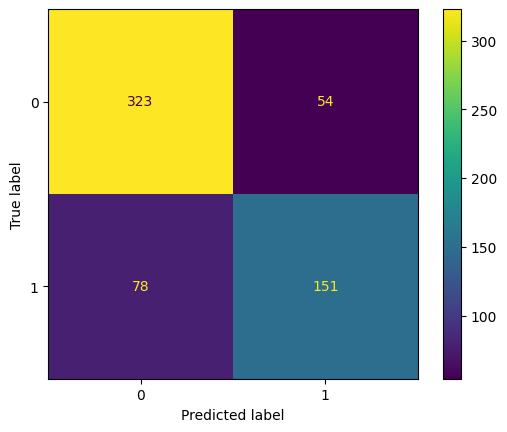

In [15]:
# View them in a confustion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds1).ravel()

cmd = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds1),
                             display_labels=gs.classes_)

cmd.plot();

In [16]:
tp

151

In [17]:
# Common Metrics

# Specificity
spec = tn / (tn+fp)
print(f'The specificity was {round(spec * 100, 2)} %.')
print('**************************************')

# Sensitivity
print(f'The sensitivity was {round(recall_score(y_test, preds1) * 100, 2)} %.')
print('**************************************')

# Precision
print(f'The precision was {round(precision_score(y_test, preds1) * 100, 2)} %.')
print('**************************************')

# F1 Score
print(f'The F1 score was {round(f1_score(y_test, preds1) * 100, 2)} %.')
print('**************************************')

The specificity was 85.68 %.
**************************************
The sensitivity was 65.94 %.
**************************************
The precision was 73.66 %.
**************************************
The F1 score was 69.59 %.
**************************************


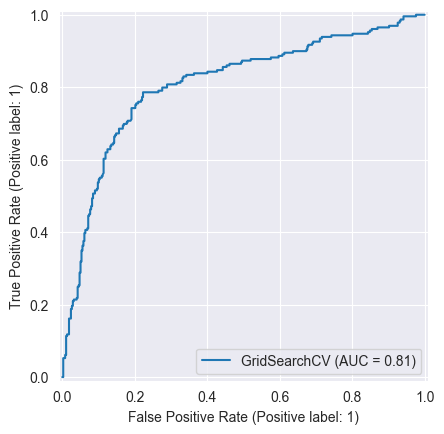

In [18]:
# Roc Curve
sns.set_style('darkgrid')
RocCurveDisplay.from_estimator(gs, X_test, y_test)
plt.legend;
plt.savefig('../assets/mnb_tvec_roc_auc.jpg');
plt.show();

In [19]:
# The curve is pretty average, checking the area under the curve
print(f'The ROC AUC score is {round(roc_auc_score(y_test, preds1) * 100, 2)} %. \
     \nThis is a ok score, 1.0 being the best and 0.5 being the worst. \
     \nThis leaves room for improvement.')

The ROC AUC score is 75.81 %.      
This is a ok score, 1.0 being the best and 0.5 being the worst.      
This leaves room for improvement.


### Multinomial Naive Bayes Evaluation

Clearly an improvement over the kNN TVEC across all measures.  It is slightly overfit, with a testing accuary of 78% (86% on training).  The confusion matrix scores were about the same, if not a touch better as was the ROC AUC score.

Let's see how it does with the TVEC transformer.

___
# 06 - Multinomial Naive Bayes with TVEC
___

In [20]:
# Building a pipeline for Logisitc Regression with TVEC

pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [21]:
# Setting up hyperparameters to explore
pipe2_parameters = {
    'tvec__max_features': range(500, 3500, 500),
    'tvec__min_df': [1, 4],
    'tvec__max_df': np.linspace(0.01, 0.90, 8),
    'tvec__stop_words': [None, 'english'],
    'mnb__alpha': [0.01, 0.02, 0.03, 0.04, 0.05]
}    

In [22]:
# Grid Search for best configuration
gs2 = GridSearchCV(pipe2, 
                 pipe2_parameters,
                 n_jobs=-1,
                  cv=5
                 )

gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'mnb__alpha': [0.01, 0.02, 0.03, 0.04, 0.05],
                         'tvec__max_df': array([0.01      , 0.13714286, 0.26428571, 0.39142857, 0.51857143,
       0.64571429, 0.77285714, 0.9       ]),
                         'tvec__max_features': range(500, 3500, 500),
                         'tvec__min_df': [1, 4],
                         'tvec__stop_words': [None, 'english']})

### Evaluate

In [23]:
# The GridSearch best results
pipe2_best_params = pd.Series(gs2.best_params_)
print('================================================')
print(f'The GridSearch best score was {round(gs2.best_score_ * 100, 2)} %.')
print('================================================')
pipe2_best_params

The GridSearch best score was 73.79 %.


mnb__alpha                0.04
tvec__max_df          0.137143
tvec__max_features        1000
tvec__min_df                 4
tvec__stop_words       english
dtype: object

In [24]:
# Scoring results on training and testing set
print(f'Training data score: {round(gs2.score(X_train, y_train) *100, 2)} %.')
print(f'Testing data score: {round(gs2.score(X_test, y_test) *100, 2)} %.')

Training data score: 81.11 %.
Testing data score: 77.23 %.


In [25]:
# Evaluate predictions
preds2 = gs2.predict(X_test)

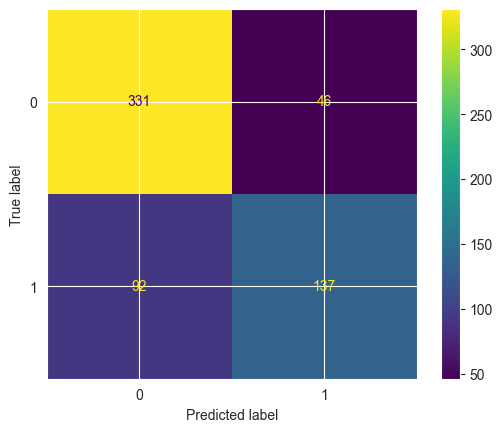

In [26]:
# View them in a confustion matrix
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, preds2).ravel()

cmd2 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds2),
                             display_labels=gs2.classes_)

cmd2.plot();

In [27]:
# Common Metrics

# Specificity
spec2 = tn2 / (tn2+fp2)
print(f'The specificity was {round(spec2 * 100, 2)} %.')
print('**************************************')

# Sensitivity
print(f'The sensitivity was {round(recall_score(y_test, preds2) * 100, 2)} %.')
print('**************************************')

# Precision
print(f'The precision was {round(precision_score(y_test, preds2) * 100, 2)} %.')
print('**************************************')

# F1 Score
print(f'The F1 score was {round(f1_score(y_test, preds2) * 100, 2)} %.')
print('**************************************')

The specificity was 87.8 %.
**************************************
The sensitivity was 59.83 %.
**************************************
The precision was 74.86 %.
**************************************
The F1 score was 66.5 %.
**************************************


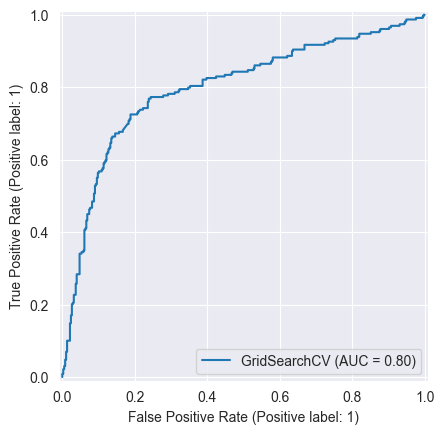

In [28]:
# Roc Curve
RocCurveDisplay.from_estimator(gs2, X_test, y_test)
plt.legend;
plt.show();

In [29]:
# The curve is quite squre, checking the area under the curve
print(f'The ROC AUC score is {round(roc_auc_score(y_test, preds2) * 100, 2)} %. \
     \nThis is a worse score, 1.0 being the best and 0.5 being the worst.')

The ROC AUC score is 73.81 %.      
This is a worse score, 1.0 being the best and 0.5 being the worst.


### Multinomial Naive Bayes TVEC Evaluation

While this model is less overfit (77% testing to 81% training) than the MNB with CVEC transformer, its overall metrics are also a touch lower.  Under these conditions, would use the MNB with CVEC transformer as it had a better F1 score which is more helpful when we are distinguishing between classes correctly.